In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
train_data, validation_data, test_data = tfds.load('deep_weeds', split=['train[:80%]', 'train[81%:90%]', 'train[91%:]'], as_supervised=True)

TARGET_SIZE = (128, 128)
TARGET_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)

train_data = train_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))
validation_data = validation_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))
test_data = test_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))


#steps = 41
train_data = train_data.shuffle(1024) #.batch(150)
validation_data = validation_data.shuffle(1024) #.batch(25)


print("Number of training samples: %d" % tf.data.experimental.cardinality(train_data))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_data))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_data))

Number of training samples: 14007
Number of validation samples: 1576
Number of test samples: 1576


tf.Tensor(
[[[[0.21960784 0.327451   0.25196078]
   [0.22352941 0.22745098 0.20294118]
   [0.38333333 0.37843138 0.3754902 ]
   ...
   [0.31862745 0.5205882  0.5392157 ]
   [0.23137255 0.39607844 0.39509803]
   [0.42941177 0.6882353  0.62058824]]

  [[0.3382353  0.45392156 0.41960785]
   [0.16960785 0.2372549  0.22352941]
   [0.35882354 0.40980393 0.41764706]
   ...
   [0.34313726 0.5352941  0.5529412 ]
   [0.2509804  0.4343137  0.42843136]
   [0.32352942 0.5441176  0.48921567]]

  [[0.29411766 0.41764706 0.44313726]
   [0.21862745 0.37156862 0.38235295]
   [0.46764705 0.595098   0.6117647 ]
   ...
   [0.3970588  0.5637255  0.5882353 ]
   [0.19509804 0.4019608  0.38627452]
   [0.20686275 0.36960784 0.33529413]]

  ...

  [[0.08333334 0.1254902  0.11960784]
   [0.07058824 0.13137256 0.11960784]
   [0.14117648 0.23921569 0.21764706]
   ...
   [0.3764706  0.56078434 0.5147059 ]
   [0.36372548 0.52156866 0.4970588 ]
   [0.09705883 0.23039216 0.2254902 ]]

  [[0.17843138 0.24607843 0.241176

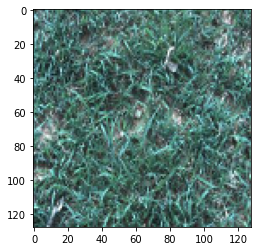

In [3]:
input = keras.Input(shape=TARGET_SHAPE)
normalizer = keras.layers.experimental.preprocessing.Normalization()
preprocess = normalizer(input)
normalizer.set_weights([np.array([0] * 3), np.array([255**2] * 3)])

image_batch, label_batch = next(iter(train_data))
test = normalizer(image_batch)
print(test)
print(label_batch)
plt.imshow(tf.reshape(test, (128, 128, 3)))

In [4]:
base_model = keras.applications.VGG19(include_top=False, weights='imagenet', pooling='avg', input_shape=TARGET_SHAPE)
base_model.trainable = False
#print(base_model.summary())
#img = train_data.take(1)
#print(img)
#image_batch, label_batch = next(iter(train_data))
#print(image_batch)
#plt.imshow(image_batch / 255.0)
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)

features = base_model(preprocess, training=False)
dense_layer = keras.layers.Dense(1024,
                                     activation='relu',
                                     kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                     bias_regularizer=keras.regularizers.l2(1e-4),
                                     activity_regularizer=keras.regularizers.l2(1e-5)
                                    )
dropout1 = keras.layers.Dropout(0.25)
dropout2 = keras.layers.Dropout(0.25)
classifier_head = keras.layers.Dense(9, 
                                     activation='softmax',
                                    )
#outputs = classifier_head(dropout(features))
#outputs = classifier_head(dense_layer(dropout1(features)))
outputs = classifier_head(dense_layer(features))
print(outputs.shape)

model = keras.Model(input, outputs)

print(model.summary())

(None, 9)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 128, 128, 3)       7         
_________________________________________________________________
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 9225      
Total params: 20,558,928
Trainable params: 534,537
Non-trainable params: 20,024,391
_________________________________________________________________
None


In [44]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=6)
mc = keras.callbacks.ModelCheckpoint('best_val_acc_vgg.h5', monitor='val_sparse_categorical_accuracy', mode='max', save_best_only=True)


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['sparse_categorical_accuracy']   
)

#print(model.summary())
history = model.fit(train_data.batch(70)
, epochs=65
, validation_data=validation_data.batch(250)
, validation_steps=7
, steps_per_epoch=201
, callbacks=[es, mc]
)

model = keras.models.load_model('best_val_acc_vgg.h5')

#model.load_weights('best_val_acc_w.h5')
#model.save_weights("classifier_head_weights.tf")

Epoch 1/65
201/201 [==============================] - 24s 119ms/step - loss: 1.4265 - sparse_categorical_accuracy: 0.5551 - val_loss: 1.2322 - val_sparse_categorical_accuracy: 0.5806
Epoch 2/65
201/201 [==============================] - 24s 120ms/step - loss: 1.1839 - sparse_categorical_accuracy: 0.6093 - val_loss: 1.1488 - val_sparse_categorical_accuracy: 0.6091
Epoch 3/65
201/201 [==============================] - 24s 118ms/step - loss: 1.1236 - sparse_categorical_accuracy: 0.6327 - val_loss: 1.1001 - val_sparse_categorical_accuracy: 0.6282
Epoch 4/65
201/201 [==============================] - 24s 118ms/step - loss: 1.0790 - sparse_categorical_accuracy: 0.6472 - val_loss: 1.0705 - val_sparse_categorical_accuracy: 0.6497
Epoch 5/65
201/201 [==============================] - 24s 118ms/step - loss: 1.0528 - sparse_categorical_accuracy: 0.6559 - val_loss: 1.0934 - val_sparse_categorical_accuracy: 0.6390
Epoch 6/65
201/201 [==============================] - 24s 118ms/step - loss: 1.0292 -

<Figure size 432x288 with 0 Axes>

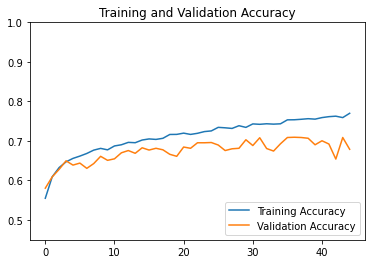

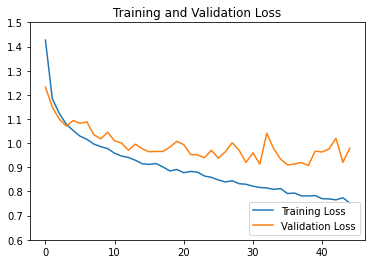

<Figure size 432x288 with 0 Axes>

In [46]:
%matplotlib inline
#print(history.history)

acc=history.history['sparse_categorical_accuracy']
val_acc=history.history['val_sparse_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.45, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.figure()


plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0.6, 1.5])
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.figure()

In [47]:
tstloss, accuracy = model.evaluate(test_data.batch(100))
print(accuracy)

16/16 [==============================] - 2s 113ms/step - loss: 0.9403 - sparse_categorical_accuracy: 0.7037
0.7036802172660828
0.7093908786773682


In [5]:
model = keras.models.load_model('best_val_acc_vgg.h5')
#model.save_weights('best_val_acc_w.h5')
#model = keras.Model(input, outputs)
#model.load_weights('best_val_acc_w.h5')
#start fine tuning

#drop = keras.layers.Dropout(0.15)
#layers = [l for l in model.layers]
#x = layers[0].output
#for i in range(1, len(layers)):
#    if i == 3:
#        x = drop(x)
#    x = layers[i](x)

#model = keras.Model(layers[0].input, x)

base_model = model.layers[2]
print(len(base_model.layers))
base_model.trainable = True

#res net 101 has a crazy number of layers.  Look at the model summary to figure out what to unfreeze  
FINE_TUNE_COUNT = 7
print(len(base_model.layers))
print(base_model.summary())

#for layer in base_model.layers[:-1 * FINE_TUNE_COUNT]:
#    layer.trainable = False
    

#note that Adam default is 0.001 
FINE_TUNING_LR = 0.000001
    
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=FINE_TUNING_LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['sparse_categorical_accuracy'],
)

print(model.summary())


23
23
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       

In [6]:
#want the model to start fine tuning from here every time
#model.load_weights("classifier_head_weights.tf")
es2 = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc2 = keras.callbacks.ModelCheckpoint('best_val_acc_vgg_fine.h5', monitor='val_sparse_categorical_accuracy', mode='max', save_best_only=True)



original_epochs = 38
fine_tuning_epochs = 40

#print(model.summary())
history_fine = model.fit(train_data.batch(70)
, epochs = original_epochs + fine_tuning_epochs + 1
, validation_data=validation_data.batch(70)
, validation_steps=23
, steps_per_epoch=201
, initial_epoch=original_epochs + 1
, callbacks = [es2, mc2]
)

Epoch 40/79
  2/201 [..............................] - ETA: 30s - loss: 0.7803 - sparse_categorical_accuracy: 0.7429WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1091s vs `on_train_batch_end` time: 0.1934s). Check your callbacks.


201/201 [==============================] - 65s 325ms/step - loss: 0.7129 - sparse_categorical_accuracy: 0.7819 - val_loss: 0.8256 - val_sparse_categorical_accuracy: 0.7329
Epoch 41/79
201/201 [==============================] - 63s 314ms/step - loss: 0.6606 - sparse_categorical_accuracy: 0.7998 - val_loss: 0.7912 - val_sparse_categorical_accuracy: 0.7494
Epoch 42/79
201/201 [==============================] - 63s 315ms/step - loss: 0.6231 - sparse_categorical_accuracy: 0.8143 - val_loss: 0.7642 - val_sparse_categorical_accuracy: 0.7506
Epoch 43/79
201/201 [==============================] - 64s 320ms/step - loss: 0.5926 - sparse_categorical_accuracy: 0.8260 - val_loss: 0.7696 - val_sparse_categorical_accuracy: 0.7595
Epoch 44/79
201/201 [==============================] - 64s 319ms/step - loss: 0.5655 - sparse_categorical_accuracy: 0.8354 - val_loss: 0.7362 - val_sparse_categorical_accuracy: 0.7690
Epoch 45/79
201/201 [==============================] - 63s 316ms/step - loss: 0.5420 - spars

In [7]:
model = keras.models.load_model('best_val_acc_vgg_fine.h5')

tstloss, accuracy = model.evaluate(test_data.batch(100))
print(accuracy)

16/16 [==============================] - 3s 186ms/step - loss: 0.7710 - sparse_categorical_accuracy: 0.7881
0.7880710363388062


<Figure size 432x288 with 0 Axes>

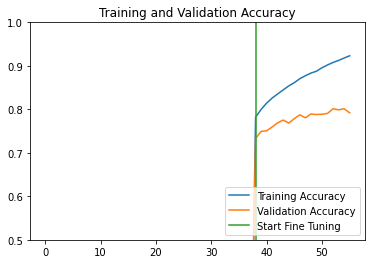

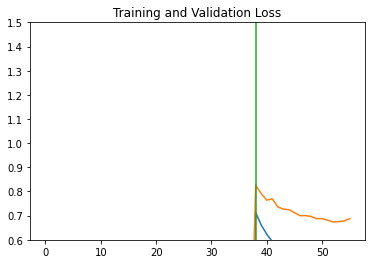

<Figure size 432x288 with 0 Axes>

In [11]:
%matplotlib inline
#print(history.history)

#fine_acc= acc[:original_epochs] + history_fine.history['sparse_categorical_accuracy']
#fine_val_acc = val_acc[:original_epochs] + history_fine.history['val_sparse_categorical_accuracy']
#fine_loss = loss[:original_epochs] + history_fine.history['loss']
#fine_val_loss= val_loss[:original_epochs] + history_fine.history['val_loss']

fine_acc= [0] * 38 + history_fine.history['sparse_categorical_accuracy']
fine_val_acc = [0] * 38 + history_fine.history['val_sparse_categorical_accuracy']
fine_loss = [0] * 38 +  history_fine.history['loss']
fine_val_loss= [0] * 38 +  history_fine.history['val_loss']


epochs=range(len(fine_acc)) # Get number of epochs
#print(acc)

plt.plot(fine_acc, label='Training Accuracy')
plt.plot(fine_val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([original_epochs,original_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.figure()


plt.plot(fine_loss, label='Training Loss')
plt.plot(fine_val_loss, label='Validation Loss')
plt.ylim([0.6, 1.5])
plt.plot([original_epochs,original_epochs],
         plt.ylim(), label='Start Fine Tuning')
#plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.figure()